<a href="https://colab.research.google.com/github/arshakRz/DDPMs/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wrote the code in colab because of the cloud GPU

In [ ]:
import tensorflow as tf
from time import time
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll
from tensorflow_probability import distributions as tfd
from keras import layers
from keras import Sequential
from keras.layers import Dense, Dropout, Input, Add, Activation, BatchNormalization, Masking
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import cv2
import imageio
from PIL import Image

In [ ]:
data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255.0

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
print(X_train.shape)

(60000, 28, 28, 1)


In [ ]:
print(y_train.shape)

(60000,)


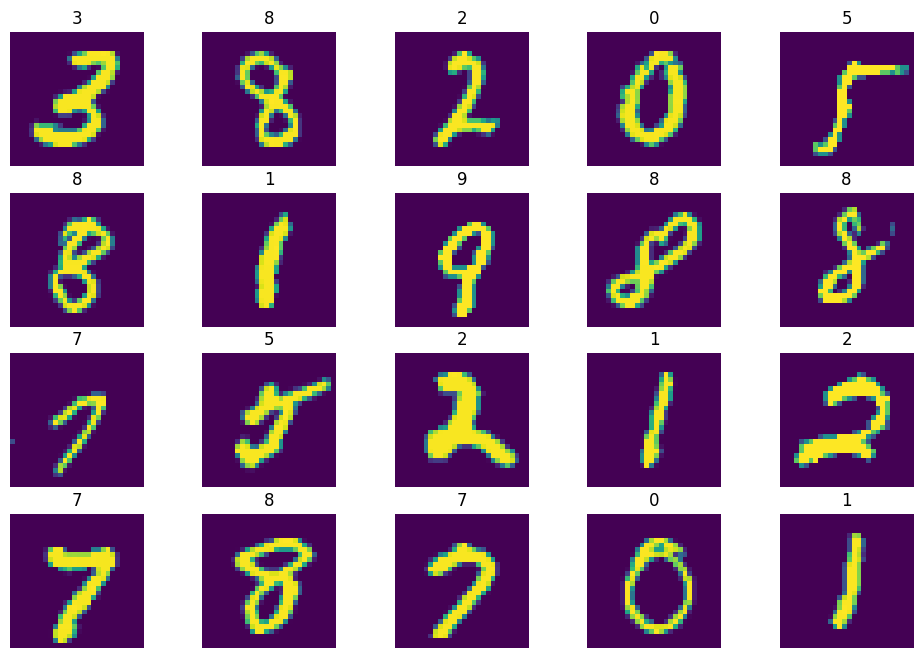

In [ ]:
plt.figure(figsize=(12,8))
for i in range(20):
  n = np.random.randint(0, X_train.shape[0])
  sample = X_train[n,:]
  plt.subplot(4,5,i+1)
  plt.imshow(sample)
  plt.title(y_train[n])
  plt.axis("off")
plt.show()

In [ ]:
class Diffusion():

  def __init__(self, input_size, steps = 1000, beta_start = 1e-4, beta_end = 0.02):
    self.steps = steps
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.beta = np.linspace(beta_start, beta_end, steps)
    self.alpha = 1-self.beta
    self.alpha_hat = np.cumprod(self.alpha)
    self.input_size = input_size
    self.model = self.make_net(self.input_size)

  def forward(self, x_t0, step):
    noise = np.random.randn(*x_t0.shape)
    return noise, np.sqrt(self.alpha_hat[step, np.newaxis, np.newaxis, np.newaxis]) * x_t0 + np.sqrt(1-self.alpha_hat[step, np.newaxis, np.newaxis, np.newaxis]) * noise

  def attention(self, x, x_add, size):
    s = x.shape
    x_att = layers.Reshape((s[1]*s[2], s[3]))(x)
    x_att = layers.Dense(size)(x_att)
    add_att = layers.Reshape((x_add.shape[1]*x_add.shape[2], x_add.shape[3]))(x_add)
    add_att = layers.Dense(size)(add_att)
    att = layers.MultiHeadAttention(128, size)(x_att, add_att)
    att = layers.Dense(s[3])(att)
    att = layers.Reshape((s[1], s[2], s[3]))(att)
    x = layers.Add()([x, att])
    x = layers.GroupNormalization(x.shape[3]//4)(x)
    return x

  def double_conv_block(self, input, size, res=0):
    x = layers.Conv2D(size, kernel_size=3, padding='same')(input)
    x = layers.Activation('gelu')(x)
    x = layers.Conv2D(size, kernel_size=3, padding='same')(x)
    if res==1:
      x = layers.Add()([x, input])
    x = layers.Activation('gelu')(x)
    x = layers.GroupNormalization(size//4)(x)
    return x

  def last_block(self, input, size):
    x = layers.Conv2D(input.shape[3], kernel_size=3, padding='same')(input)
    x = layers.Activation('gelu')(x)
    x = layers.Conv2D(input.shape[3], kernel_size=3, padding='same')(input)
    x = layers.Add()([x, input])
    x = layers.Activation('gelu')(x)
    x = layers.GroupNormalization(input.shape[3]//4)(x)
    x = layers.Conv2D(size, kernel_size=3, padding='same')(x)
    return x


  def emb_block(self, x, x_ts):
    x_ts = layers.Dense(16)(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    x_ts = layers.Dense(32)(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    x_ts = layers.Reshape((1, 1, 32))(x_ts)
    for i in range(tf.dtypes.cast(np.log2(x.shape[1]), tf.int32)-1):
      x_ts = layers.UpSampling2D(size=(2, 2))(x_ts)
      x_ts = x_tsr = layers.Conv2D(x.shape[3]*np.power(2, i+3), kernel_size=3, padding='same')(x_ts)
      x_ts = layers.Activation('relu')(x_ts)
      x_ts = layers.Conv2D(x.shape[3]*np.power(2, i+3), kernel_size=3, padding='same')(x_ts)
      x_ts = layers.Add()([x_ts, x_tsr])
      x_ts = layers.Activation('relu')(x_ts)
      if x_ts.shape[3]//4 != 0:
        x_ts = layers.GroupNormalization(x_ts.shape[3]//4)(x_ts)
    return x_ts

  def make_net(self, input_size):

    x_input = layers.Input(shape=(input_size, input_size, 1))

    x_ts = x_ts_input = layers.Input(shape=(1,))

    x_cg = x_cg_input = layers.Input(shape=(1,))

    x = self.double_conv_block(x_input, 8)

    x_ts = self.emb_block(x_input, x_ts)

    x_cg = Masking(mask_value=-1.0)(x_cg)

    x_cg = self.emb_block(x_input, x_cg)

    x = self.double_conv_block(x, 8, res=1)

    x = x1 = self.double_conv_block(x, 16)

    x = layers.MaxPool2D(2)(x)

    x = self.double_conv_block(x, 16, res=1)

    #x = x2 = self.double_conv_block(x, 32)
    x = self.double_conv_block(x, 32)

    x = self.attention(x, x_ts, 32)

    x = self.double_conv_block(x, 32, res = 1)

    x = x2 = self.attention(x, x_cg, 32)
    #x = self.attention(x, x_cg, 32)

    x = layers.MaxPool2D(2)(x)

    x = self.double_conv_block(x, 32, res=1)

    x = self.double_conv_block(x, 32, res=1)

    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Concatenate()([x, x2])

    x = self.double_conv_block(x, 64, res=1)

    x = self.double_conv_block(x, 16)

    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Concatenate()([x, x1])

    x = self.double_conv_block(x, 32, res=1)

    x = self.double_conv_block(x, 8)

    x = self.last_block(x, 1)

    print(x.shape)

    model = Model([x_input, x_ts_input, x_cg_input], x)

    return model


  def train(self, x, c, epochs, batch_size=32):

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    loss_fn = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train_step(x, t, c, epsilon):
      with tf.GradientTape() as tape:
        loss = loss_fn(self.model([x, t, c]), epsilon)
      gradients = tape.gradient(loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
      return loss

    for epoch in range(epochs):
      print("Epoch:", epoch + 1)
      for batch_start in range(0, x.shape[0], batch_size):
          batch_end = batch_start + batch_size

          x0_batch = x[batch_start:batch_end, :]

          t_batch = np.random.randint(low=1, high=self.steps, size=(batch_size,))

          c_batch = c[batch_start:batch_end]

          if np.random.uniform(0, 1)<0.2:
            c_bath = -np.ones(*c_batch.shape)

          epsilon_batch, noisy_x_batch = self.forward(x0_batch, t_batch)

          loss = train_step(noisy_x_batch, t_batch, c_batch, epsilon_batch)

          if batch_start % 10 == 0:
              print("Batch:", batch_start, "Loss:", loss.numpy())

  def get_pos_emb(self, seq_len, emb_len, n = 10000):
    P = np.zeros((seq_len, emb_len))
    for k in range(seq_len):
      for i in np.arange(int(emb_len/2)):
        denom = np.power(n, 2*i/emb_len)
        P[k, 2*i] = np.sin(k/denom)
        P[k, 2*i+1] = np.cos(k/denom)
    return P

  def sample(self, c = 2, w = 3, plot = 0):
    im_list = []
    xt = np.random.randn(self.input_size, self.input_size, 1)
    xt = xt.reshape(-1, self.input_size, self.input_size, 1)
    xt = tf.convert_to_tensor(xt)
    im_list.append(np.squeeze(xt))
    if plot == 1:
      plt.figure(figsize=(10,8))
    for t in range(self.steps-1, -1, -1):
      if t>0:
        z = np.random.randn(self.input_size, self.input_size, 1)
        z = z.reshape(-1, self.input_size, self.input_size, 1)
      else:
        z = 0
      t_m = tf.convert_to_tensor(np.reshape(t, (1,)))
      pred = self.model.predict([xt, t_m, tf.convert_to_tensor(np.reshape(c, (1,)))], verbose = 0)
      if w > 0:
        pred_ng = self.model.predict([xt, t_m, tf.convert_to_tensor(np.reshape(-1, (1,)))], verbose = 0)
        pred = (1+w)*pred - w*pred_ng
      xt = 1/np.sqrt(self.alpha[t]) * (xt-((1-self.alpha[t])/np.sqrt(1-self.alpha_hat[t]))*pred) + np.sqrt(self.beta[t]) * z
      if plot == 1:
        if np.mod(t,100) == 0:
          plt.subplot(1,10,t//100 + 1)
          plt.imshow(np.squeeze(xt))
          plt.axis("off")
      im_list.append(np.squeeze(xt))
    if plot == 1:
      plt.show()
    return xt, np.asarray(im_list)

  def sample_batch(self, w = 3, size=20):
    xt = np.random.randn(self.input_size, self.input_size, size)
    xt = xt.reshape(-1, self.input_size, self.input_size, 1)
    xt = tf.convert_to_tensor(xt)
    c = np.random.randint(0, 10, size)
    for t in range(self.steps-1, -1, -1):
      if t>0:
        z = np.random.randn(self.input_size, self.input_size, size)
        z = z.reshape(-1, self.input_size, self.input_size, 1)
      else:
        z = 0
      t_m = tf.convert_to_tensor(np.reshape(np.repeat(t, size), (size,)))
      pred = self.model.predict([xt, t_m, tf.convert_to_tensor(np.reshape(c, (size,)))], verbose = 0)
      if w > 0:
        pred_ng = self.model.predict([xt, t_m, tf.convert_to_tensor(np.reshape(np.repeat(-1, size), (size,)))], verbose = 0)
        pred = (1+w)*pred - w*pred_ng
      xt = 1/np.sqrt(self.alpha[t]) * (xt-((1-self.alpha[t])/np.sqrt(1-self.alpha_hat[t]))*pred) + np.sqrt(self.beta[t]) * z
    return xt, c

  def ddim_sample(self, steps, w = 5, size = 20, ddim_eta = 1, plot = 0):

    c = np.random.randint(0, 10, size)
    tao = np.asarray(list(range(0, self.steps, self.steps//steps))) + 1

    ddim_alpha = self.alpha_hat[tao]
    ddim_alpha_sqrt = np.sqrt(ddim_alpha)
    ddim_alpha_prev = np.concatenate([self.alpha_hat[0:1], self.alpha_hat[tao[:-1]]])
    ddim_sigma = (ddim_eta*((1-ddim_alpha_prev)/(1 -ddim_alpha)*(1-ddim_alpha/ddim_alpha_prev))**.5)
    ddim_sqrt_one_minus_alpha = (1. - ddim_alpha) ** .5

    xt = np.random.randn(self.input_size, self.input_size, size)
    xt = xt.reshape(-1, self.input_size, self.input_size, 1)
    xt = tf.convert_to_tensor(xt)

    for i in range(steps-1, -1, -1):
      t_m = tf.convert_to_tensor(np.reshape(np.repeat(tao[i], size), (size,)))
      eps = self.model.predict([xt, t_m, tf.convert_to_tensor(np.reshape(c, (size,)))], verbose = 0)
      if w > 0:
        eps_ng = self.model.predict([xt, t_m, tf.convert_to_tensor(np.reshape(np.repeat(-1, size), (size,)))], verbose = 0)
        eps = (1+w)*eps - w*eps_ng
      noise = np.random.randn(self.input_size, self.input_size, size)
      noise = noise.reshape(-1, self.input_size, self.input_size, 1)
      xt = (ddim_alpha_prev[i] ** 0.5) * (xt - ddim_sqrt_one_minus_alpha[i] * eps) / (ddim_alpha[i] ** 0.5) + ((1 - ddim_alpha_prev[i] - ddim_sigma[i] **2 ) ** 0.5) * eps + ddim_sigma[i] * noise

    return xt, c

In [ ]:
diffusion = Diffusion(input_size = 28)

(None, 28, 28, 1)


In [ ]:
diffusion.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_109 (Conv2D)            (None, 28, 28, 8)    80          ['input_10[0][0]']               
                                                                                                  
 activation_118 (Activation)    (None, 28, 28, 8)    0           ['conv2d_109[0][0]']             
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

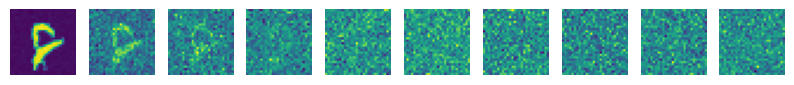

In [ ]:
sample = X_train[np.random.randint(0, X_train.shape[0]),:]
plt.figure(figsize=(10,8))
for i in range(10):
  noise, noisy = diffusion.forward(sample, i*100)
  plt.subplot(1,10,i+1)
  plt.imshow(noisy)
  plt.axis("off")

In [ ]:
diffusion.train(X_train, y_train, 30)

Streaming output truncated to the last 5000 lines.
Batch: 6240 Loss: 0.10335476254586838
Batch: 6400 Loss: 0.06978368096359404
Batch: 6560 Loss: 0.06408045444083403
Batch: 6720 Loss: 0.08457878255802499
Batch: 6880 Loss: 0.13310393777710172
Batch: 7040 Loss: 0.07714312613487088
Batch: 7200 Loss: 0.057541888481724014
Batch: 7360 Loss: 0.059762805736664676
Batch: 7520 Loss: 0.055625201841785335
Batch: 7680 Loss: 0.05574265944496523
Batch: 7840 Loss: 0.10761924400191458
Batch: 8000 Loss: 0.10139779191880145
Batch: 8160 Loss: 0.06782564915497846
Batch: 8320 Loss: 0.07659075555742934
Batch: 8480 Loss: 0.13409443946187158
Batch: 8640 Loss: 0.09067823692803935
Batch: 8800 Loss: 0.06866182636368896
Batch: 8960 Loss: 0.041445258404175137
Batch: 9120 Loss: 0.05133889846477319
Batch: 9280 Loss: 0.057268962560666686
Batch: 9440 Loss: 0.07139492911367462
Batch: 9600 Loss: 0.061520706243585466
Batch: 9760 Loss: 0.06069461616596283
Batch: 9920 Loss: 0.07778289750952691
Batch: 10080 Loss: 0.0531514711

KeyboardInterrupt: ignored

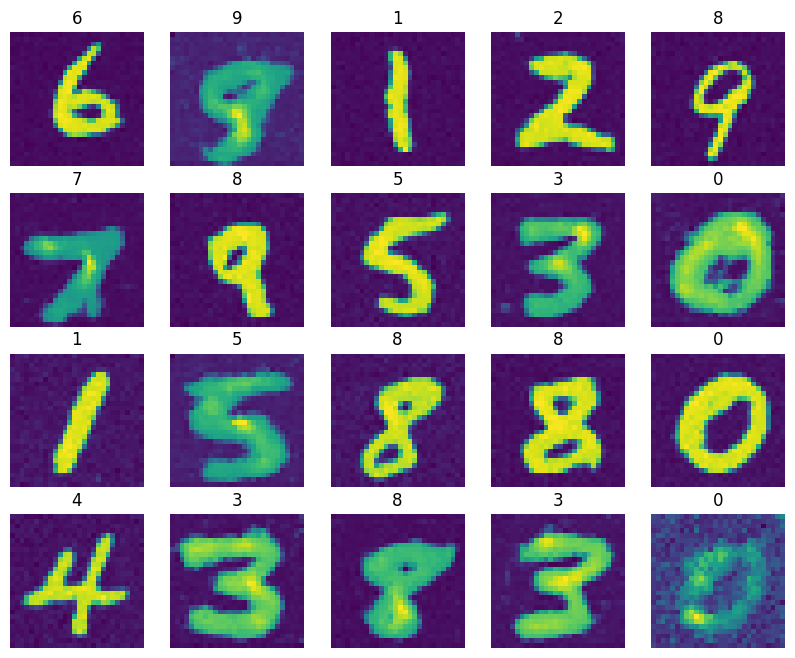

In [ ]:
samples, c = diffusion.ddim_sample(20, w=0.8, size=20)
samples = np.squeeze(samples)
plt.figure(figsize=(10,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(samples[i,:,:])
  plt.title(c[i])
  plt.axis("off")
plt.show()

In [ ]:
def save_gif(img_list, path="", interval=10):
    imgs = []
    for im in img_list:
        im = np.array(im)
        im = (im + 1) * 127.5
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    imgs = iter(imgs)
    img = next(imgs)
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

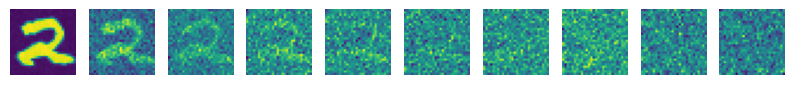

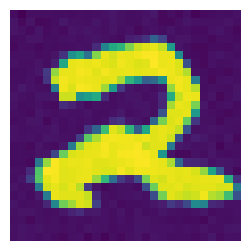

In [ ]:
sample, im_list = diffusion.sample(plot = 1, c=2, w=0.5)
plt.figure(figsize=(3,3))
plt.imshow(np.squeeze(sample))
plt.axis("off")
plt.show()
save_gif(im_list,'out.gif')

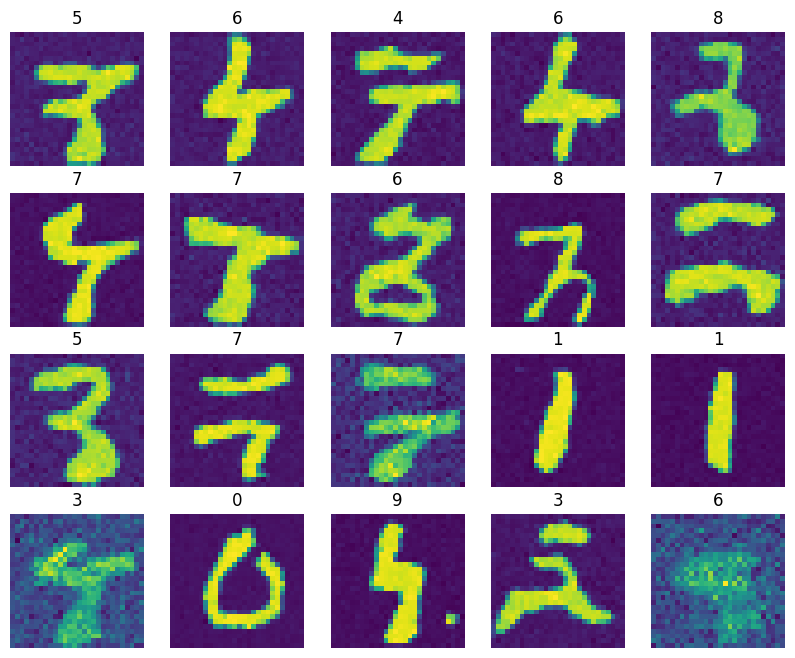

In [ ]:
samples, c = diffusion.sample_batch()
samples = np.squeeze(samples)
plt.figure(figsize=(10,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(samples[i,:,:])
  plt.title(c[i])
  plt.axis("off")
plt.show()